Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 80/80 [00:11<00:00,  6.83it/s]


Epoch 0, Loss: 1.9569588899612427
Epoch 10, Loss: 1.6558603048324585
Epoch 20, Loss: 1.0560388565063477
Epoch 30, Loss: 0.4391600489616394
Epoch 40, Loss: 0.13593903183937073
Epoch 50, Loss: 0.04648679867386818
Epoch 60, Loss: 0.021495824679732323
Epoch 70, Loss: 0.013051691465079784
Epoch 80, Loss: 0.009422832168638706
Epoch 90, Loss: 0.0074823168106377125
Epoch 100, Loss: 0.0062530506402254105
Epoch 110, Loss: 0.005376043729484081
Epoch 120, Loss: 0.004702464677393436
Epoch 130, Loss: 0.004161875229328871
Epoch 140, Loss: 0.003716206643730402
Epoch 150, Loss: 0.0033420457039028406
Epoch 160, Loss: 0.0030238640028983355
Epoch 170, Loss: 0.002750525251030922
Epoch 180, Loss: 0.0025138393975794315
Epoch 190, Loss: 0.0023073325864970684


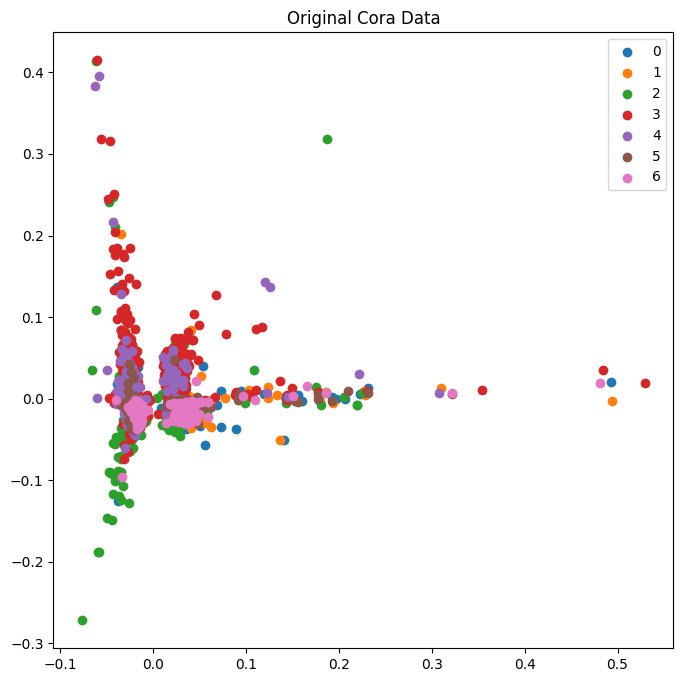

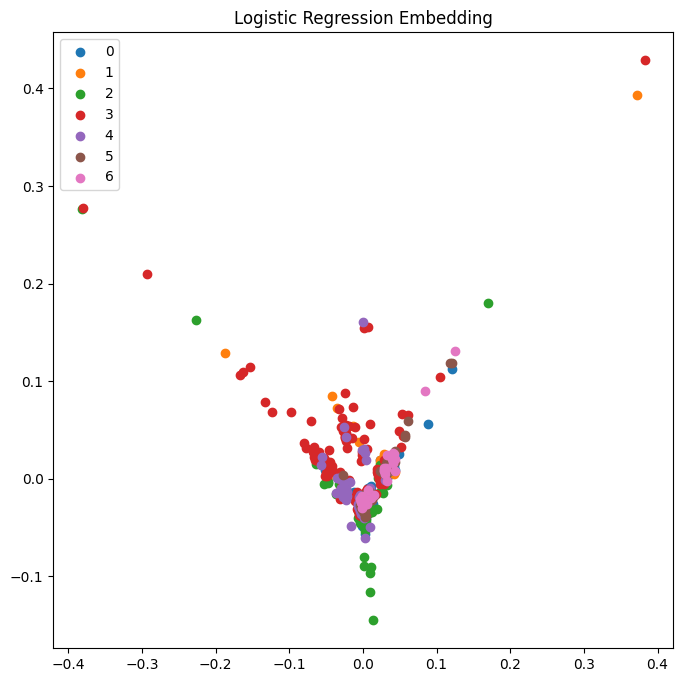

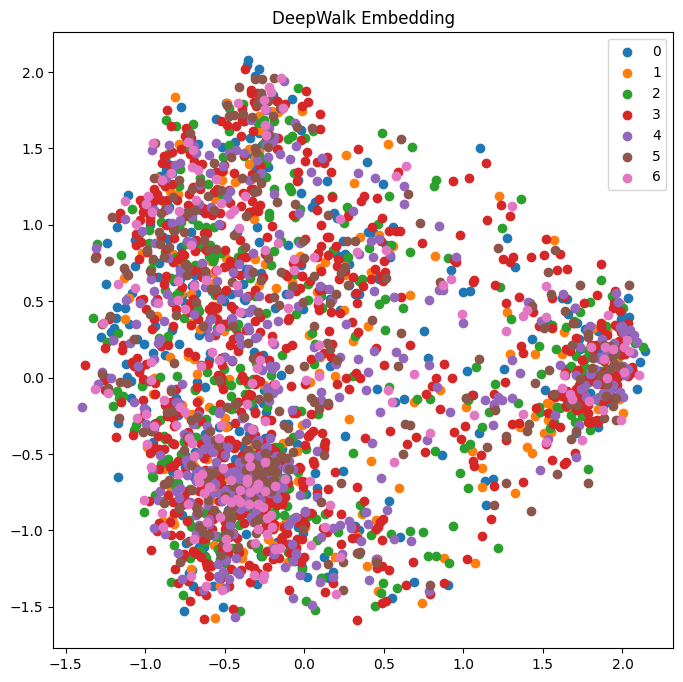

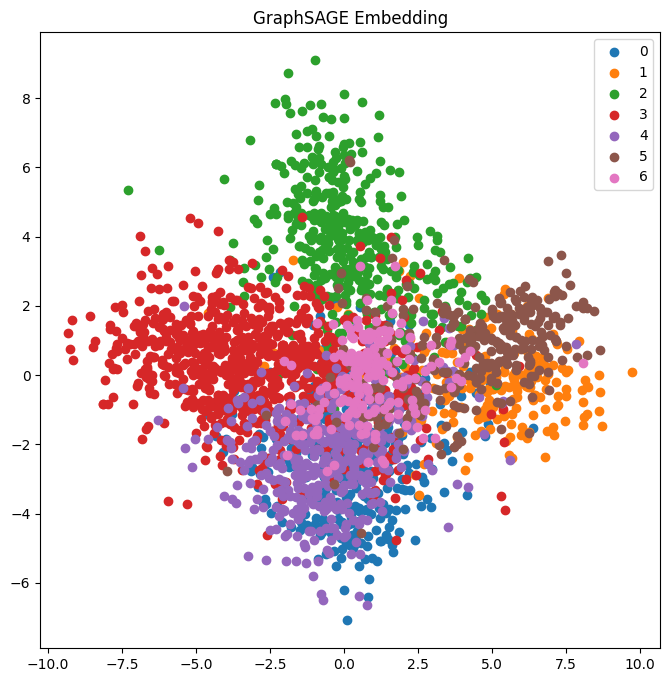

Logistic Regression Accuracy: 0.4095940959409594
DeepWalk Accuracy: 0.25830258302583026
GraphSAGE Accuracy: 0.763


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import SAGEConv
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from node2vec import Node2Vec
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load Cora dataset(lấy dữ liệu từ cora)
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]


features = data.x.numpy()
labels = data.y.numpy()
edge_index = data.edge_index.numpy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Logistic Regression
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

# DeepWalk (using Node2Vec)
G = nx.Graph()
G.add_edges_from(edge_index.T)
node2vec = Node2Vec(G, dimensions=128, walk_length=10, num_walks=80, workers=1)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embeddings = np.array([model.wv[str(node)] for node in G.nodes()])
X_train_deepwalk, X_test_deepwalk, y_train_deepwalk, y_test_deepwalk = train_test_split(node_embeddings, labels, test_size=0.2, random_state=42, stratify=labels)
lr_clf_deepwalk = LogisticRegression(max_iter=1000)
lr_clf_deepwalk.fit(X_train_deepwalk, y_train_deepwalk)
lr_pred_deepwalk = lr_clf_deepwalk.predict(X_test_deepwalk)
lr_accuracy_deepwalk = accuracy_score(y_test_deepwalk, lr_pred_deepwalk)

# GraphSAGE
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(dataset.num_features, 16, dataset.num_classes).to(device)
data = data.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
    return test_acc

for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

graphsage_accuracy = test()

def plot_embedding(X, y, title=None):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8, 8))
    for i in range(len(set(y))):
        plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=str(i))
    plt.legend()
    if title:
        plt.title(title)
    plt.show()


plot_embedding(features, labels, title="Original Cora Data")


plot_embedding(X_test, y_test, title="Logistic Regression Embedding")


plot_embedding(node_embeddings, labels, title="DeepWalk Embedding")


def get_graphsage_embedding(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
    return out.cpu().numpy()

graphsage_embeddings = get_graphsage_embedding(model, data)
plot_embedding(graphsage_embeddings, labels, title="GraphSAGE Embedding")

print("Logistic Regression Accuracy:", lr_accuracy)
print("DeepWalk Accuracy:", lr_accuracy_deepwalk)
print("GraphSAGE Accuracy:", graphsage_accuracy)
